In [60]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
pd.set_option('display.max_columns', None)

In [63]:
with open("allfeatures.csv") as f:
    data = pd.read_csv(f)
IDS = data['ID']
data = data.drop("ID",axis=1)

In [64]:
data.at[data['category'].isin(['EC','EC*', 'EC/ESD', 'ED', 'ED*' ,'ESD', 'ESD/ED']),'numcategory']=0
data.at[data['category'].isin(['ea' ,'eb','ew']),'numcategory']=1
data.at[data['category'].isin(['QSO']),'numcategory']=2
data.at[data['category'].isin(['rr_ab', 'rr_c', 'rr_dm', 'rr_mf', 'rr_u']),'numcategory']=3
data.at[data['category'].isin(['del_scu']),'numcategory']=4
data.at[data['category'].isin(['rs','lpv', 'mult']),'numcategory']=5

data['temp_cl'].loc[data['cl']=='unknown']='unknown'
data['temp_cl'].loc[data['cl']=='QSO']='QSO' #variable quasars
data['temp_cl'].loc[data['cl']=='del_scu']='del_scu' #delta scuti variables
data['temp_cl'].loc[data['cl']=='EC']='EC' #Contact binaries in ASAS-3
data['temp_cl'].loc[data['cl']=='ED']='ED' #Detached eclipsing binaries
data['temp_cl'].loc[data['cl']=='ESD']='ESD' #Semi-detached eclipsing binaries
data['temp_cl'].loc[data['cl']=='EC/ESD']='EC/ESD'
data['temp_cl'].loc[data['cl']=='ESD/ED']='ESD/ED'
data['temp_cl'].loc[data['cl']=='EC*']='EC*'
data['temp_cl'].loc[data['cl']=='ED*']='ED*'
data['temp_cl'].loc[data['cl']=='mult']='mult'
data['temp_cl'].loc[data['cl']=='ew']='ew' #W Ursae Majoris-type eclipsing variables
data['temp_cl'].loc[data['cl']=='ea']='ea' #beta Persei-type (Algol) eclipsing systems
data['temp_cl'].loc[data['cl']=='eb']='eb' #beta Lyrae-type eclipsing systems
data['temp_cl'].loc[data['cl']=='rr_ab']='rr_ab' #RR Lyrae variables with asymmetric light curves
data['temp_cl'].loc[data['cl']=='rr_c']='rr_c' #RR Lyrae variables with nearly symmetric
data['temp_cl'].loc[data['cl']=='rr_d']='rr_d' #Double-mode RR Lyrae stars which pulsate...
data['temp_cl'].loc[data['cl']=='bl']='bl' #RR Lyrae stars showing the Blazhko effect.
data['temp_cl'].loc[data['cl']=='rs']='rs' #non-eclipsing RS CVn stars
data['temp_cl'].loc[data['cl']=='acep']='acep' #Anomalous Cepheids
data['temp_cl'].loc[data['cl']=='cep-ii']='cep-ii' ####need to confirm which star this is...
data['temp_cl'].loc[data['cl']=='hads']='hads' #High Amplitude delta Scuti stars
data['temp_cl'].loc[data['cl']=='lads']='lads' #low-amplitude delta Scuti stars
data['temp_cl'].loc[data['cl']=='lpv']='lpv' #Long Period Variables 
data['temp_cl'].loc[data['cl']=='ell']='ell' #ellipsoidal binary system
data['temp_cl'].loc[data['cl']=='hump']='hump' #LPV Humps
data['temp_cl'].loc[data['cl']=='pceb']='pceb' #post common envelope binary planetary system
data['temp_cl'].loc[data['cl']=='ea_up']='ea_up' 
data['temp_cl'].loc[data['cl']=='RRAB']='rr_ab' #RR Lyrae variables with asymmetric light curves
data['temp_cl'].loc[data['cl']=='RRmf']='rr_mf'
data['temp_cl'].loc[data['cl']=='RRC']='rr_c' #RR Lyrae variables with nearly symmetric
data['temp_cl'].loc[data['cl']=='RRdm']='rr_dm' #Detached main-sequence systems?
data['temp_cl'].loc[data['cl']=='RRu']='rr_u'

In [4]:
print(np.unique(data['category'].values))
data.groupby("numcategory").count()
data

['EC' 'EC*' 'EC/ESD' 'ED' 'ED*' 'ESD' 'ESD/ED' 'QSO' 'del_scu' 'ea' 'eb'
 'ew' 'lpv' 'mult' 'rr_ab' 'rr_c' 'rr_dm' 'rr_mf' 'rr_u' 'rs']


,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Color,Con,Eta_color,Eta_e,FluxPercentileRatioMid20,FluxPercentileRatioMid35,FluxPercentileRatioMid50,FluxPercentileRatioMid65,FluxPercentileRatioMid80,Freq1_harmonics_amplitude_0,Freq1_harmonics_amplitude_1,Freq1_harmonics_amplitude_2,Freq1_harmonics_amplitude_3,Freq1_harmonics_rel_phase_0,Freq1_harmonics_rel_phase_1,Freq1_harmonics_rel_phase_2,Freq1_harmonics_rel_phase_3,Freq2_harmonics_amplitude_0,Freq2_harmonics_amplitude_1,Freq2_harmonics_amplitude_2,Freq2_harmonics_amplitude_3,Freq2_harmonics_rel_phase_0,Freq2_harmonics_rel_phase_1,Freq2_harmonics_rel_phase_2,Freq2_harmonics_rel_phase_3,Freq3_harmonics_amplitude_0,Freq3_harmonics_amplitude_1,Freq3_harmonics_amplitude_2,Freq3_harmonics_amplitude_3,Freq3_harmonics_rel_phase_0,Freq3_harmonics_rel_phase_1,Freq3_harmonics_rel_phase_2,Freq3_harmonics_rel_phase_3,ID,LinearTrend,MaxSlope,Mean,Meanvariance,MedianAbsDev,MedianBRP,PairSlopeTrend,PercentAmplitude,PercentDifferenceFluxPercentile,PeriodLS,Period_fit,Psi_CS,Psi_eta,Q31,Q31_color,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonJ,StetsonK,StetsonK_AC,StetsonL,category,numcategory
0,0.10750,0.939395,11.0,0.385965,0.036107,-0.004085,517.521076,-0.343339,0.000000,0.004620,46.058529,0.266010,0.334975,0.458128,0.650246,0.817734,0.070051,0.030593,0.057544,0.009037,0.0,1.554298,2.010946,1.269508,0.080235,0.043322,0.033967,0.032501,0.0,0.627402,0.643616,-0.866633,0.060776,0.028423,0.008454,0.025399,0.0,-0.070618,1.956684,0.861776,449978,-0.000048,0.0230,18.686351,0.003224,0.0530,0.228070,-0.166667,0.006531,0.010867,1467.500000,0.000062,0.426619,0.429414,0.09300,0.09925,0.426619,0.048711,68.0,-1.001964,0.060238,-0.000218,0.875043,0.749589,-0.000221,QSO,2.0
1,0.27400,1.000000,2.0,0.166667,0.074327,-0.011465,260.220947,-0.269897,0.034483,NaN,49.876034,0.042601,0.071749,0.172646,0.304933,0.598655,0.151424,0.130552,0.052377,0.090741,0.0,1.180519,1.417931,1.335819,0.197997,0.166440,0.104268,0.152533,0.0,0.713564,0.770169,0.940852,0.286482,0.178669,0.077949,0.135096,0.0,-0.324909,1.818855,1.698555,4928219,-0.000025,0.0710,19.341517,0.006147,0.0290,0.666667,0.033333,0.021858,0.023102,1053.789474,0.001848,0.234711,0.337390,0.07550,0.06900,0.196936,1.826358,6.0,3.707759,0.118899,0.000137,0.633103,0.765728,0.000105,QSO,2.0
2,0.26750,0.956036,1.0,0.459459,234.034299,-0.966957,0.063171,-0.957351,0.000000,NaN,2019.237249,0.258621,0.325670,0.547893,0.750958,0.932950,0.156143,0.024208,0.081755,0.049768,0.0,-1.532845,0.711129,-0.626538,0.119759,0.031344,0.036320,0.039213,0.0,0.324933,1.214408,0.227956,0.112660,0.022330,0.048745,0.058704,0.0,0.269595,0.411611,0.148065,3202291,-0.000001,0.5320,14.784135,0.011500,0.1500,0.189189,-0.033333,0.020781,0.035335,38.048780,0.999898,0.211734,1.639767,0.29000,0.06900,0.185205,0.208067,2.0,-1.029703,0.170021,0.000137,0.781329,0.735317,0.000105,ew,1.0
3,0.24200,1.000000,9.0,0.255319,0.042330,-0.010407,454.272437,-0.189026,0.000000,0.001157,54.931672,0.109914,0.329741,0.495690,0.653017,0.782328,0.221703,0.161064,0.075074,0.096146,0.0,-1.944919,-1.624889,-1.134120,0.151171,0.081677,0.121111,0.199778,0.0,0.649133,0.680009,1.339513,0.200179,0.137053,0.023608,0.147548,0.0,-0.935488,0.485724,-1.103961,1792218,-0.000115,0.0575,19.229574,0.007822,0.0880,0.404255,-0.233333,0.020167,0.024055,2948.000000,0.000067,0.424109,0.265548,0.22700,0.26000,0.424109,-0.723098,16.0,-0.550635,0.150413,-0.000395,0.703542,0.805310,-0.000356,QSO,2.0
4,0.20900,1.000000,8.0,0.418182,0.097931,-0.016084,197.604873,-0.063306,0.000000,0.145373,22.864522,0.444444,0.523457,0.639506,0.713580,0.814815,0.226007,0.203616,0.135883,0.118249,0.0,-0.028407,-0.178507,1.417249,0.324525,0.219331,0.158611,0.159014,0.0,0.212675,0.114867,-1.494006,0.386388,0.326279,0.280896,0.317264,0.0,-1.251680,-0.355657,0.389565,434011,0.000167,0.0460,19.351618,0.007306,0.1130,0.127273,-0.100000,0.017067,0.020883,4402.500000,0.000049,0.444284,0.424729,0.25500,0.24400,0.444284,-0.115967,58.0,

In [5]:
#prep data matrix

A = data.replace(np.nan, 0).fillna(0.0).replace(np.inf,10**6).to_numpy()
labels = A[:,-1:]
labelnames = A[:,-2:-1]
A = A[:,:-2].astype(np.float64)

In [17]:
QSO.iloc[0:500]

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Color,Con,Eta_color,Eta_e,FluxPercentileRatioMid20,FluxPercentileRatioMid35,FluxPercentileRatioMid50,FluxPercentileRatioMid65,FluxPercentileRatioMid80,Freq1_harmonics_amplitude_0,Freq1_harmonics_amplitude_1,Freq1_harmonics_amplitude_2,Freq1_harmonics_amplitude_3,Freq1_harmonics_rel_phase_0,Freq1_harmonics_rel_phase_1,Freq1_harmonics_rel_phase_2,Freq1_harmonics_rel_phase_3,Freq2_harmonics_amplitude_0,Freq2_harmonics_amplitude_1,Freq2_harmonics_amplitude_2,Freq2_harmonics_amplitude_3,Freq2_harmonics_rel_phase_0,Freq2_harmonics_rel_phase_1,Freq2_harmonics_rel_phase_2,Freq2_harmonics_rel_phase_3,Freq3_harmonics_amplitude_0,Freq3_harmonics_amplitude_1,Freq3_harmonics_amplitude_2,Freq3_harmonics_amplitude_3,Freq3_harmonics_rel_phase_0,Freq3_harmonics_rel_phase_1,Freq3_harmonics_rel_phase_2,Freq3_harmonics_rel_phase_3,ID,LinearTrend,MaxSlope,Mean,Meanvariance,MedianAbsDev,MedianBRP,PairSlopeTrend,PercentAmplitude,PercentDifferenceFluxPercentile,PeriodLS,Period_fit,Psi_CS,Psi_eta,Q31,Q31_color,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonJ,StetsonK,StetsonK_AC,StetsonL,category,numcategory
0,0.10750,0.939395,11.0,0.385965,0.036107,-0.004085,517.521076,-0.343339,0.000000,0.004620,46.058529,0.266010,0.334975,0.458128,0.650246,0.817734,0.070051,0.030593,0.057544,0.009037,0.0,1.554298,2.010946,1.269508,0.080235,0.043322,0.033967,0.032501,0.0,0.627402,0.643616,-0.866633,0.060776,0.028423,0.008454,0.025399,0.0,-0.070618,1.956684,0.861776,449978,-0.000048,0.023000,18.686351,0.003224,0.053,0.228070,-0.166667,0.006531,0.010867,1467.500000,6.222125e-05,0.426619,0.429414,0.09300,0.09925,0.426619,0.048711,68.0,-1.001964,0.060238,-0.000218,0.875043,0.749589,-0.000221,QSO,2.0
1,0.27400,1.000000,2.0,0.166667,0.074327,-0.011465,260.220947,-0.269897,0.034483,NaN,49.876034,0.042601,0.071749,0.172646,0.304933,0.598655,0.151424,0.130552,0.052377,0.090741,0.0,1.180519,1.417931,1.335819,0.197997,0.166440,0.104268,0.152533,0.0,0.713564,0.770169,0.940852,0.286482,0.178669,0.077949,0.135096,0.0,-0.324909,1.818855,1.698555,4928219,-0.000025,0.071000,19.341517,0.006147,0.029,0.666667,0.033333,0.021858,0.023102,1053.789474,1.847937e-03,0.234711,0.337390,0.07550,0.06900,0.196936,1.826358,6.0,3.707759,0.118899,0.000137,0.633103,0.765728,0.000105,QSO,2.0
3,0.24200,1.000000,9.0,0.255319,0.042330,-0.010407,454.272437,-0.189026,0.000000,0.001157,54.931672,0.109914,0.329741,0.495690,0.653017,0.782328,0.221703,0.161064,0.075074,0.096146,0.0,-1.944919,-1.624889,-1.134120,0.151171,0.081677,0.121111,0.199778,0.0,0.649133,0.680009,1.339513,0.200179,0.137053,0.023608,0.147548,0.0,-0.935488,0.485724,-1.103961,1792218,-0.000115,0.057500,19.229574,0.007822,0.088,0.404255,-0.233333,0.020167,0.024055,2948.000000,6.739109e-05,0.424109,0.265548,0.22700,0.26000,0.424109,-0.723098,16.0,-0.550635,0.150413,-0.000395,0.703542,0.805310,-0.000356,QSO,2.0
4,0.20900,1.000000,8.0,0.418182,0.097931,-0.016084,197.604873,-0.063306,0.000000,0.145373,22.864522,0.444444,0.523457,0.639506,0.713580,0.814815,0.226007,0.203616,0.135883,0.118249,0.0,-0.028407,-0.178507,1.417249,0.324525,0.219331,0.158611,0.159014,0.0,0.212675,0.114867,-1.494006,0.386388,0.326279,0.280896,0.317264,0.0,-1.251680,-0.355657,0.389565,434011,0.000167,0.046000,19.351618,0.007306,0.113,0.127273,-0.100000,0.017067,0.020883,4402.500000,4.922995e-05,0.444284,0.424729,0.25500,0.24400,0.444284,-0.115967,58.0,-1.356525,0.141389,0.000611,0.874836,0.724376,0.000543,QSO,2.0
5,0.22450,0.999997,5.0,0.370370,0.053438,-0.008349,375.281078,-0.305034,0.000000,NaN,39.879425,0.215311,0.397129,0.614833,0.700957,0.796651,0.166032,0.127447,0.119330,0.313353,0.0,0.894692,2.362591,2.104034,0.191211,0.103219,0.108515,0.113959,0.0,0.595400,-0.155974,-0.714504,0.112189,0.064077,0.085255,0.086360,0.0,2.619987,0.203016,2.501612,2636798,0.000112,0.061000,20.054148,0.006817,0.075,0.222222,0.033333,0.016838,0.020885,1560.000000,1.493459e-06,0.381316,0.452975,0.25150,0.2537

In [50]:
data.iloc[:,:-2].columns

Index(['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std',
       'CAR_mean', 'CAR_sigma', 'CAR_tau', 'Color', 'Con', 'Eta_color',
       'Eta_e', 'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35',
       'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65',
       'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_0',
       'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2',
       'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_0',
       'Freq1_harmonics_rel_phase_1', 'Freq1_harmonics_rel_phase_2',
       'Freq1_harmonics_rel_phase_3', 'Freq2_harmonics_amplitude_0',
       'Freq2_harmonics_amplitude_1', 'Freq2_harmonics_amplitude_2',
       'Freq2_harmonics_amplitude_3', 'Freq2_harmonics_rel_phase_0',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0',
       'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2',
       'Freq3_harmonics_amplitude_3

In [65]:
#Standardize
from sklearn.preprocessing import StandardScaler
standardized = data.replace(np.nan, 0).fillna(0.0).replace(np.inf,10**6).iloc[:,:-2].copy()
a=StandardScaler().fit_transform(standardized)
labels = data.iloc[:,-2:]
standardized = pd.DataFrame(a,columns=data.iloc[:,:-2].columns)
standardized=pd.concat([standardized,labels],axis=1)

#Split by category
eclipse = standardized.loc[data['numcategory']==0]
eclipsevariable = standardized.loc[data['numcategory']==1]
QSO = standardized.loc[data['numcategory']==2].iloc[0:300]
rr =  standardized.loc[data['numcategory']==3]
del_scu = standardized.loc[data['numcategory']==4]
other = standardized.loc[data['numcategory']==5]

In [66]:
ec = np.array_split(eclipse, 5)
ecv = np.array_split(eclipsevariable, 5)
qs = np.array_split(QSO, 5)
r = np.array_split(rr, 5)
ds = np.array_split(del_scu, 5)
ot = np.array_split(other, 5)

groups = {}
labels = {}

for i in range(5):
    frames = [ec[i],ecv[i],qs[i],r[i],ds[i],ot[i]]
    groups[i] = pd.concat(frames,axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
    labels[i] = groups[i]['numcategory'].values
    
groups[2]

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Color,Con,Eta_color,Eta_e,FluxPercentileRatioMid20,FluxPercentileRatioMid35,FluxPercentileRatioMid50,FluxPercentileRatioMid65,FluxPercentileRatioMid80,Freq1_harmonics_amplitude_0,Freq1_harmonics_amplitude_1,Freq1_harmonics_amplitude_2,Freq1_harmonics_amplitude_3,Freq1_harmonics_rel_phase_0,Freq1_harmonics_rel_phase_1,Freq1_harmonics_rel_phase_2,Freq1_harmonics_rel_phase_3,Freq2_harmonics_amplitude_0,Freq2_harmonics_amplitude_1,Freq2_harmonics_amplitude_2,Freq2_harmonics_amplitude_3,Freq2_harmonics_rel_phase_0,Freq2_harmonics_rel_phase_1,Freq2_harmonics_rel_phase_2,Freq2_harmonics_rel_phase_3,Freq3_harmonics_amplitude_0,Freq3_harmonics_amplitude_1,Freq3_harmonics_amplitude_2,Freq3_harmonics_amplitude_3,Freq3_harmonics_rel_phase_0,Freq3_harmonics_rel_phase_1,Freq3_harmonics_rel_phase_2,Freq3_harmonics_rel_phase_3,LinearTrend,MaxSlope,Mean,Meanvariance,MedianAbsDev,MedianBRP,PairSlopeTrend,PercentAmplitude,PercentDifferenceFluxPercentile,PeriodLS,Period_fit,Psi_CS,Psi_eta,Q31,Q31_color,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonJ,StetsonK,StetsonK_AC,StetsonL,category,numcategory
0,-0.219793,0.337816,-1.331029,-1.310840,-0.135912,-0.370197,-0.035029,-4.144185,-0.431464,-0.230948,0.894082,-0.858557,-0.956462,-1.378789,-0.529749,0.220078,-0.462135,-0.886009,-0.817094,-0.568794,0.0,0.698171,0.456238,1.430544,-0.340065,-0.449662,-0.534199,-0.569604,0.0,-0.269848,-0.551715,-0.509354,-0.272048,-0.354772,-0.371561,-0.382881,0.0,1.695104,0.598390,0.595448,-0.161394,-0.255573,0.181770,-0.239099,-0.816399,2.007080,-0.194774,0.668030,-0.171579,-0.648827,0.570887,-1.413207,1.784834,-0.868313,-0.902662,-1.450884,1.920255,-0.436499,1.499559,-0.213331,0.644172,-1.504944,0.455233,0.528353,ED,0.0
1,-0.617317,0.337816,-1.331029,-2.368537,3.427450,-1.348245,-0.035029,-5.688596,-0.431464,-0.230948,1.190384,-1.110054,-1.509152,-1.653549,-2.353577,-1.166830,-0.714029,-0.972978,-0.922192,-1.013256,0.0,-0.591773,0.228467,-1.097099,-0.378348,-0.506365,-0.650084,-0.590759,0.0,-0.531060,0.966292,0.219810,-0.281363,-0.363438,-0.407708,-0.409071,0.0,-0.681787,-0.527903,-1.250132,-0.195518,-0.255573,-0.459729,-0.821084,-1.366048,1.538748,-0.718064,-0.244563,-0.528713,-0.648066,3.479676,-2.552720,3.772041,-1.142301,-1.164948,-2.032793,2.354329,-0.436499,1.897120,-0.893177,0.266302,-1.700359,-0.802984,0.324564,ED*,0.0
2,0.400998,0.337816,-1.331029,-2.036367,0.156778,-0.756786,-0.035029,-4.260730,-0.431464,-0.230948,0.826171,-1.407136,-1.703711,-2.209048,-1.717532,-2.375380,-0.477968,-0.673448,-0.435153,-0.855792,0.0,0.917512,-0.464526,0.925682,-0.343219,-0.487454,-0.343408,-0.468911,0.0,-0.217863,-1.047917,-1.239006,-0.268080,-0.362221,-0.370951,-0.403570,0.0,-0.091808,-0.127045,1.428359,0.122942,-0.255573,-0.751960,0.052979,-1.155544,2.750901,1.375098,1.275140,0.641004,-0.648927,3.474979,-2.292194,3.533359,-1.170207,-1.154457,-1.616490,2.614425,-0.436499,2.391774,-0.031636,0.413177,-1.830908,0.386936,0.247230,ED,0.0
3,-0.110882,0.337816,-1.331029,-1.791611,-0.099751,-0.401155,-0.035029,-4.824974,-0.431464,-0.210252,1.223004,-0.269587,-0.815274,-1.440594,-1.172056,1.139076,-0.496016,-0.784845,-0.798456,-0.877553,0.0,-0.670686,0.050329,-0.244867,-0.344533,-0.511592,-0.565673,-0.426887,0.0,-0.431009,0.392994,-1.091083,-0.275942,-0.366738,-0.383627,-0.371607,0.0,-1.246251,-1.096961,-1.717393,-0.531000,-0.255573,-0.537424,-0.233824,-0.687757,0.216398,0.851807,-0.014263,-0.017844,-0.648794,1.886154,-1.816812,2.792847,-0.848018,-0.795125,-0.937717,1.698882,-0.436499,0.703044,-0.296044,-0.195284,-1.037977,0.693718,-0.174014,ED,0.0
4,1.702482,0.337816,-1.331029,-0.231372,0.015015,-1.365777,-0.035029,-4.278757,-0.431464,-0.068119,0.687140,0.466594,1.438254,1.326591,0.932824,0.354141,-0.097907,0.422256,-0.540682,-0.214592,0.0,-0.576743,0.371165,-2.189698,-0.136939,-0.418001,-0.581032,-0.170446,0.0,0.708127,0.008733,1.133628,-0.247525,-0.341769,-0.376281,-0.304465,0.0,-0.939270,-0.09325

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 5., 5., 5.])

#### LASSO 

In [78]:
from itertools import combinations
lst = [0,1,2,3,4]
for combo in combinations(lst, 4):  # 2 for pairs, 3 for triplets, etc
    print( combo[0], sum(lst)-sum(combo))


0 4
0 3
0 2
0 1
1 0


In [113]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

from itertools import combinations
lst = [0,1,2,3,4]

alphas = np.logspace(-4,1,50)

errors = []

for alpha in alphas:
    errors.append([])
    for combo in combinations(lst, 4):  # 2 for pairs, 3 for triplets, etc
        othernum = sum(lst)-sum(combo)
        model = Lasso(alpha = alpha, max_iter=10000)
        test = pd.concat([groups[combo[0]],groups[combo[1]],groups[combo[2]],groups[combo[3]]],axis=0, join='outer', ignore_index=True, keys=None,
                  levels=None, names=None, verify_integrity=False, copy=True).to_numpy()[:,:-2].astype(np.float64)
        label = np.concatenate([labels[combo[0]],labels[combo[1]],labels[combo[2]],labels[combo[3]]]).ravel()
        model.fit(test, label)
        errors[-1].append(model.score(groups[othernum].to_numpy()[:,:-2].astype(np.float64),labels[othernum]))
avgerror = np.apply_along_axis(np.mean,1,np.array(errors))

Text(0.5, 1.0, 'LASSO Regression')

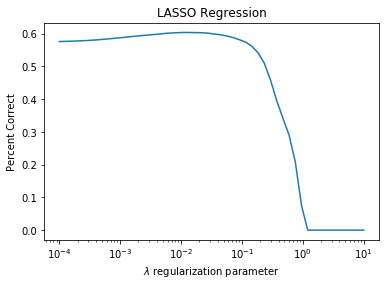

In [116]:
fig,ax = plt.subplots()
ax.plot(alphas,avgerror)
ax.set_xscale('log')
ax.set_xlabel("$\lambda$ regularization parameter")
ax.set_ylabel("Percent Correct")
ax.set_title("LASSO Regression")

In [117]:
#Find important features
model = Lasso(alpha = alphas[avgerror.argmax()])
test = pd.concat([groups[0],groups[1],groups[2],groups[3],groups[4]],axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True).to_numpy()[:,:-2].astype(np.float64)
label = np.concatenate([labels[0],labels[1],labels[2],labels[3],labels[4]]).ravel()
model.fit(test, label)
importance = np.abs(model.coef_)
idx_features = (-importance).argsort()[:7]
name_features = np.array(feature_names)[idx_features]

name_features=np.array(feature_names)[np.where(importance>1e-8)]
print('Selected features: {}'.format(name_features))

Selected features: ['Amplitude' 'Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'Color'
 'Eta_e' 'FluxPercentileRatioMid20' 'FluxPercentileRatioMid65'
 'Freq1_harmonics_amplitude_0' 'Freq1_harmonics_amplitude_2'
 'Freq1_harmonics_rel_phase_2' 'Freq1_harmonics_rel_phase_3'
 'Freq2_harmonics_rel_phase_1' 'Freq2_harmonics_rel_phase_3'
 'Freq3_harmonics_rel_phase_3' 'LinearTrend' 'MaxSlope' 'Mean' 'MedianBRP'
 'PercentAmplitude' 'Period_fit' 'Psi_eta' 'Q31_color' 'Rcs' 'Skew'
 'SlottedA_length' 'SmallKurtosis' 'StetsonK' 'StetsonK_AC']


In [154]:
#create latex table of features and coeffs
items = np.array([np.array(feature_names)[np.where(importance>1e-8)],importance[np.where(importance>1e-8)]]).T
feats = pd.DataFrame(items,columns =['Feature','Coefficient'])

print(feats.sort_values(by='Coefficient',ascending=False).to_latex(float_format="{:0.2g}".format,index=False))

\begin{tabular}{ll}
\toprule
                     Feature & Coefficient \\
\midrule
                       Color &        0.41 \\
                        Skew &        0.26 \\
                 LinearTrend &        0.13 \\
                         Rcs &        0.12 \\
              Autocor\_length &        0.11 \\
 Freq1\_harmonics\_amplitude\_2 &       0.092 \\
               SmallKurtosis &       0.081 \\
                    StetsonK &        0.08 \\
                  Beyond1Std &       0.066 \\
                  Period\_fit &       0.057 \\
 Freq1\_harmonics\_amplitude\_0 &       0.047 \\
                     Psi\_eta &       0.044 \\
                   Amplitude &       0.036 \\
                   Q31\_color &       0.032 \\
 Freq1\_harmonics\_rel\_phase\_2 &       0.031 \\
                    CAR\_mean &       0.026 \\
 Freq1\_harmonics\_rel\_phase\_3 &       0.025 \\
                    MaxSlope &       0.022 \\
             SlottedA\_length &        0.02 \\
 Freq3\_harmonics\_rel

In [162]:
pd.concat([groups[combo[0]],groups[combo[1]],groups[combo[2]],groups[combo[3]]],axis=0, join='outer', ignore_index=True, keys=None,
                  levels=None, names=None, verify_integrity=False, copy=True)[name_features[:8]]#.to_numpy()[:,:-2].astype(np.float64)

,Amplitude,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,Color,Eta_e,FluxPercentileRatioMid20,FluxPercentileRatioMid65,Freq1_harmonics_amplitude_0,Freq1_harmonics_amplitude_2,Freq1_harmonics_rel_phase_2,Freq1_harmonics_rel_phase_3,Freq2_harmonics_rel_phase_1,Freq2_harmonics_rel_phase_3,Freq3_harmonics_rel_phase_3,LinearTrend,MaxSlope,Mean,MedianBRP,PercentAmplitude,Period_fit,Psi_eta,Q31_color,Rcs,Skew,SlottedA_length,SmallKurtosis,StetsonK,StetsonK_AC
0,-0.445783,-1.331029,0.451988,0.290462,-0.725851,-4.890504,1.895260,2.394275,0.803062,-0.588206,-0.844978,0.112029,0.425554,1.639151,1.688817,1.013859,-0.340495,-0.255573,-0.829997,-1.252879,-0.623651,2.918563,2.823297,0.230411,-1.181517,-0.230754,-0.455139,-0.705526,0.805895,-0.019405
1,1.179710,-1.331029,-1.406994,0.168527,-1.081658,-4.485304,1.456018,-1.040668,-1.166905,-0.289623,-0.957208,0.214814,0.159476,0.925237,1.655840,1.773075,0.222321,-0.255572,-0.186743,2.029620,1.687805,1.797492,2.425287,-0.622017,-1.420027,1.973701,-0.455139,1.030111,-0.764437,-0.392136
2,2.257927,-1.331029,-1.868535,4.577061,4.797147,-5.397678,2.504194,-1.435805,-1.264152,-0.081581,-0.130300,0.238374,0.056535,-1.056472,-1.668160,-0.264877,-1.857733,-0.255570,-0.269517,3.015371,5.105997,3.478903,1.452423,-0.847582,-1.500143,2.854843,-0.455139,2.898174,-3.292689,-1.238835
3,0.534414,-1.331029,-2.225856,-0.026227,-0.650130,-3.442143,0.535579,-0.696637,-2.130850,-0.473929,-0.796359,-0.366537,-1.061060,0.378932,-1.042451,-0.267061,-0.577832,-0.255573,-2.901981,2.153711,1.956854,0.782832,1.004203,-0.889548,-1.307949,3.009328,-0.436499,3.346408,-3.151010,0.206060
4,2.650006,-1.331029,-0.894171,-0.184627,1.270078,-4.316095,0.577429,0.904111,1.511154,0.182490,-0.912808,0.374071,0.379684,-1.344944,-0.043054,1.104750,0.743436,-0.255572,-0.045855,-0.481508,2.529135,2.433800,2.320311,3.390951,-1.586945,0.725844,-0.436499,-0.616987,0.898656,0.723146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,-0.622763,-1.331029,0.481126,-0.056536,-0.415624,0.657966,-0.513360,0.341936,1.108171,-0.585999,-0.616935,0.181615,0.162270,-0.072841,1.722577,0.460335,-0.388575,3.912772,-0.757486,-0.134225,-0.377565,3.468570,2.427641,0.080908,-1.586714,-0.896742,-0.399220,-0.647558,1.145763,-2.562123
613,-1.052961,-1.331029,0.131474,4.521802,-1.243982,0.463352,-0.513360,-0.749960,0.198465,-0.712827,-0.915231,-0.987391,-1.668930,-0.211665,-1.062376,-1.144047,-0.015421,3.912772,0.503035,-0.682567,-1.206996,3.479607,2.759399,-0.677097,-1.890975,-0.099341,-0.455139,-0.595484,0.315117,-0.686926
614,-1.172762,-1.331029,-0.945454,-0.259852,-0.003029,-2.372436,0.136381,0.870170,-0.022093,-0.694445,-1.140592,1.537535,-0.596216,-0.610939,0.334172,2.469664,0.107911,-0.255574,-2.125731,0.370672,-0.785545,-0.142939,1.102380,1.206113,-0.933789,-0.894552,-0.399220,0.594868,-1.586445,0.012006
615,0.098771,-1.331029,1.183728,4.742656,-2.775289,0.934289,-0.513360,0.195311,0.808783,-0.581824,-0.824061,-0.414205,-1.035882,0.113478,-1.157966,-1.411947,-0.268417,3.912772,0.379080,-0.979122,-0.178547,3.140613,2.996999,0.490074,-2.461583,-0.654290,-0.455139,-0.621727,0.690954,-1.719737


### KNN

In [189]:
from sklearn.neighbors import KNeighborsClassifier

errors = []

for combo in combinations(lst, 4):  # 2 for pairs, 3 for triplets, etc
    othernum = sum(lst)-sum(combo)
    model = KNeighborsClassifier(n_neighbors=10)
    test = pd.concat([groups[combo[0]],groups[combo[1]],groups[combo[2]],groups[combo[3]]],axis=0, join='outer', ignore_index=True, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True)[name_features[:25]].to_numpy()[:,:-2].astype(np.float64)
    label = np.concatenate([labels[combo[0]],labels[combo[1]],labels[combo[2]],labels[combo[3]]]).ravel()
    model.fit(test, label)
    errors.append(model.score(groups[othernum][name_features[:25]].to_numpy()[:,:-2].astype(np.float64),labels[othernum]))
    print(np.where(model.predict(groups[othernum][name_features[:25]].to_numpy()[:,:-2].astype(np.float64))>4))
# avgerror = np.apply_along_axis(np.mean,1,np.array(errors))

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([154]),)
(array([], dtype=int64),)


In [182]:
errors
model.predict(groups[othernum][name_features[:25]].to_numpy()[:,:-2].astype(np.float64))
# labels[othernum]

array([3., 0., 2., 3., 2., 0., 0., 0., 1., 1., 0., 0., 1., 2., 1., 0., 1.,
       1., 3., 3., 1., 3., 1., 1., 1., 1., 3., 3., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 4., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 3., 3., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 2., 2., 3., 3., 4., 3., 2.,
       4., 4., 2.])

In [69]:
importance

array([0.        , 0.        , 0.10885364, 0.11481342, 0.0385804 ,
       0.01240637, 0.        , 0.44105344, 0.        , 0.00976316,
       0.00339371, 0.        , 0.        , 0.        , 0.00513859,
       0.01926709, 0.04224338, 0.        , 0.        , 0.        ,
       0.        , 0.02338931, 0.01543505, 0.06149107, 0.        ,
       0.        , 0.00199774, 0.04465032, 0.        , 0.        ,
       0.        , 0.01140746, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01649728, 0.04027507, 0.03366283,
       0.06671591, 0.00659974, 0.        , 0.        , 0.        ,
       0.        , 0.01572334, 0.02351066, 0.        , 0.        ,
       0.06083953, 0.        , 0.01786313, 0.        , 0.        ,
       0.15745787, 0.2076883 , 0.00998685, 0.06876542, 0.        ,
       0.04398924, 0.06524744, 0.00574961, 0.        ])

### Neural Net

In [230]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,500), random_state=1)
clf.fit(test, label)
clf.score(groups[othernum][name_features[:25]].to_numpy()[:,:-2].astype(np.float64),labels[othernum])

0.9038461538461539

In [219]:
nodes = np.linspace(1,150, 15,dtype=int)
nodes

array([  1,  11,  22,  32,  43,  54,  64,  75,  86,  96, 107, 118, 128,
       139, 150])

In [247]:
from sklearn.neural_network import MLPClassifier

errors = []


alphas = np.logspace(-4,1,50)

errors = []
count =0
for param in params:
    errors.append([])
    if count %50 ==0:
        print(count)
    count+=1
    for combo in combinations(lst, 4):  # 2 for pairs, 3 for triplets, etc
        othernum = sum(lst)-sum(combo)
        model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=param, random_state=1)
        test = pd.concat([groups[combo[0]],groups[combo[1]],groups[combo[2]],groups[combo[3]]],axis=0, join='outer', ignore_index=True, keys=None,
                  levels=None, names=None, verify_integrity=False, copy=True)[name_features[:25]].to_numpy()[:,:-2].astype(np.float64)
        label = np.concatenate([labels[combo[0]],labels[combo[1]],labels[combo[2]],labels[combo[3]]]).ravel()
        model.fit(test, label)
        errors[-1].append(model.score(groups[othernum][name_features[:25]].to_numpy()[:,:-2].astype(np.float64),labels[othernum]))
#         print(np.where(model.predict(groups[othernum][name_features[:25]].to_numpy()[:,:-2].astype(np.float64))>4))
avgerror = np.apply_along_axis(np.mean,1,np.array(errors))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600


In [334]:
avgerror_nn #= avgerror
errors_nn #= errors

In [240]:
params = []
params2 = []
params3 = []
for i in nodes:
    params.append(tuple([i]))
for i in params:
    for n in nodes:
        params2.append((i[0],n))
for i in params:
    for m in params:
        for n in nodes:
            params3.append((i[0],m[0],n))

In [276]:
params1 = []
for i in nodes:
    params1.append(tuple([i]))

# params.extend(params2)
# params.extend(params3)

In [249]:
avgerror.argmax()

1098

In [336]:
idx_features = (-avgerror).argsort()[:50]
# params[idx_features]

In [337]:
print(np.array(params)[idx_features])
np.array(avgerror)[idx_features]

[(32, 128, 32) (22, 43, 86) (118, 22, 150) (107, 86, 32) (139, 43, 107)
 (43, 96, 54) (96, 118, 150) (107, 139, 118) (139, 75, 75) (150, 64, 54)
 (150, 107, 96) (107, 139, 54) (32, 75) (150, 107, 64) (150, 139, 128)
 (139, 11, 22) (64, 43, 96) (128, 32, 96) (43, 150, 150) (54, 150, 86)
 (107, 107, 118) (107, 86, 107) (64, 128, 43) (43, 128, 64) (64, 107, 54)
 (43, 75, 118) (54, 54, 96) (107, 150, 118) (96, 75, 22) (64, 54, 43)
 (139, 118, 64) (118, 86, 32) (64,) (118, 139, 75) (128, 139, 86)
 (107, 150, 86) (139, 22, 150) (96, 118, 107) (139, 75, 107)
 (107, 118, 150) (107, 118, 128) (96, 75, 128) (128, 96, 64) (64, 75, 139)
 (128, 64, 139) (96, 107, 43) (150, 75, 64) (86, 43, 54) (43, 86, 96)
 (107, 96, 107)]


array([0.92376629, 0.9236395 , 0.92249044, 0.92246704, 0.92234809,
       0.9212011 , 0.92119283, 0.92115953, 0.92112579, 0.92109205,
       0.91991948, 0.91986822, 0.91986039, 0.91985201, 0.91983492,
       0.91981   , 0.91978464, 0.91975896, 0.91970084, 0.91863754,
       0.91861197, 0.91860468, 0.91860282, 0.91858704, 0.91856179,
       0.91855298, 0.91855232, 0.91853622, 0.91852849, 0.91852707,
       0.91851913, 0.91850259, 0.9185015 , 0.91848594, 0.91736321,
       0.91734722, 0.91732197, 0.91731326, 0.91730521, 0.91729683,
       0.9172879 , 0.91726277, 0.91726255, 0.91726244, 0.91725439,
       0.91724644, 0.91724579, 0.91723806, 0.91723719, 0.91722958])

In [271]:


np.apply_along_axis(len,1,np.array([list(i) for i in params]))

AxisError: axis 1 is out of bounds for array of dimension 1

In [274]:
np.array([np.array(i) for i in params])

array([array([1]), array([11]), array([22]), ..., array([150, 150, 128]),
       array([150, 150, 139]), array([150, 150, 150])], dtype=object)

In [275]:
np.array(params)

array([(1,), (11,), (22,), ..., (150, 150, 128), (150, 150, 139),
       (150, 150, 150)], dtype=object)

In [303]:
x1 = np.asarray(params[0:len(params1)])
x2 = np.asarray(params[len(params1):(len(params2)+len(params1))])
x3 = np.asarray(params[(len(params2)+len(params1)):])
x1 = np.apply_along_axis(sum,1,x1)
x2 = np.apply_along_axis(sum,1,x2)
x3 = np.apply_along_axis(sum,1,x3)

y1 = avgerror[0:len(params1)]
y2 = avgerror[len(params1):(len(params2)+len(params1))]
y3 = avgerror[(len(params2)+len(params1)):]

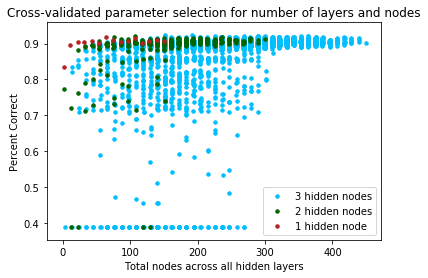

In [335]:
fig,ax= plt.subplots()

ax.scatter(x3,y3,c='deepskyblue',s=12,label='3 hidden nodes')

ax.scatter(x=x2,y=y2,c='darkgreen',s=12,label='2 hidden nodes')
ax.scatter(x=x1,y=y1,c='firebrick',s=12,label='1 hidden node')
ax.legend()
ax.set_xlabel("Total nodes across all hidden layers")
ax.set_ylabel("Percent Correct")
ax.set_title("Cross-validated parameter selection for number of layers and nodes")
plt.savefig("NN_CV_params.png",bbox_inches='tight')

In [307]:
y1

array([0.83462609, 0.8952745 , 0.90564061, 0.90429903, 0.90828808,
       0.90170978, 0.9185015 , 0.91081017, 0.9042912 , 0.90693899,
       0.91604786, 0.90178564, 0.90817958, 0.910776  , 0.9069822 ])

In [298]:
np.asarray(params[len(params1):(len(params2)+len(params1))])

array([[  1,   1],
       [  1,  11],
       [  1,  22],
       [  1,  32],
       [  1,  43],
       [  1,  54],
       [  1,  64],
       [  1,  75],
       [  1,  86],
       [  1,  96],
       [  1, 107],
       [  1, 118],
       [  1, 128],
       [  1, 139],
       [  1, 150],
       [ 11,   1],
       [ 11,  11],
       [ 11,  22],
       [ 11,  32],
       [ 11,  43],
       [ 11,  54],
       [ 11,  64],
       [ 11,  75],
       [ 11,  86],
       [ 11,  96],
       [ 11, 107],
       [ 11, 118],
       [ 11, 128],
       [ 11, 139],
       [ 11, 150],
       [ 22,   1],
       [ 22,  11],
       [ 22,  22],
       [ 22,  32],
       [ 22,  43],
       [ 22,  54],
       [ 22,  64],
       [ 22,  75],
       [ 22,  86],
       [ 22,  96],
       [ 22, 107],
       [ 22, 118],
       [ 22, 128],
       [ 22, 139],
       [ 22, 150],
       [ 32,   1],
       [ 32,  11],
       [ 32,  22],
       [ 32,  32],
       [ 32,  43],
       [ 32,  54],
       [ 32,  64],
       [ 32,